# SEG Exercise Alpha Miner
Data is from the PM4PY project

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
events = pd.read_csv('interval_event_log.csv')
events['time:timestamp'] = pd.to_datetime(events['time:timestamp'])

#events.columns = ['patient', 'action', 'resource', 'datetime']
#events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,case:concept:name,concept:name,time:timestamp,start_timestamp
0,C1,place order,2015-01-05 09:02:50+00:00,2015-01-05 09:00:07+00:00
1,C2,place order,2015-01-05 10:54:11+00:00,2015-01-05 10:18:21+00:00
2,C3,place order,2015-01-05 12:06:56+00:00,2015-01-05 11:54:49+00:00
3,C4,place order,2015-01-05 14:16:11+00:00,2015-01-05 14:07:45+00:00
4,C5,place order,2015-01-05 15:44:36+00:00,2015-01-05 15:33:38+00:00


In [3]:
print('{} has {} rows and {} columns.'.format('interval_event_log.csv', events.shape[0], events.shape[1]))


interval_event_log.csv has 8109 rows and 4 columns.


In [4]:
# How many cases
events['case:concept:name'].nunique()

1266

# Descriptive Statistics

### How many events per case?

Text(0, 0.5, 'Number of cases')

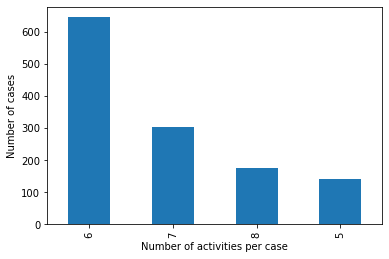

In [5]:
events['case:concept:name'].value_counts().value_counts().plot(kind='bar')
plt.xlabel('Number of activities per case')
plt.ylabel('Number of cases')

In [6]:
# median number of events per case
events['case:concept:name'].value_counts().median()

6.0

### Action occurrences

Text(0, 0.5, 'number of occurrences')

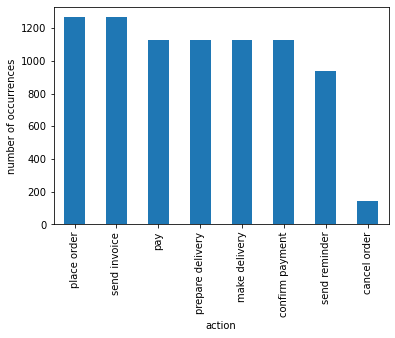

In [7]:
events['concept:name'].value_counts().plot(kind='bar')
plt.xlabel('action')
plt.ylabel('number of occurrences')

In [8]:
# In how many cases, the “pay” activity is conducted
events[events['concept:name']=='pay']['case:concept:name'].nunique() / events['case:concept:name'].nunique()

0.8886255924170616

# Process Mining

In [9]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [10]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

#eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Footprint Analysis

In [11]:
# footprint analysis
fp_log = footprints_discovery.apply(eventlog, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

### end activities

In [12]:
fp_log['end_activities']

{'cancel order', 'confirm payment', 'make delivery'}

### Occurences of binary relations

In [13]:
fp_log['dfg']

Counter({('place order', 'send invoice'): 1258,
         ('send invoice', 'pay'): 638,
         ('pay', 'prepare delivery'): 1117,
         ('prepare delivery', 'make delivery'): 895,
         ('make delivery', 'confirm payment'): 895,
         ('prepare delivery', 'confirm payment'): 230,
         ('confirm payment', 'make delivery'): 230,
         ('send invoice', 'send reminder'): 620,
         ('send reminder', 'send reminder'): 316,
         ('send reminder', 'cancel order'): 141,
         ('send reminder', 'pay'): 479,
         ('place order', 'pay'): 8,
         ('pay', 'send invoice'): 8,
         ('send invoice', 'prepare delivery'): 8})

### Causalities

In [ ]:
fp_log['sequence']

### Parallel

In [ ]:
fp_log['parallel']

### Directly-follows graph

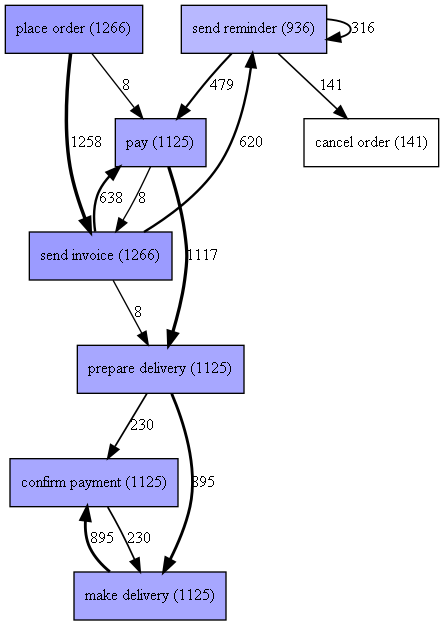

In [14]:
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

### Alpha miner

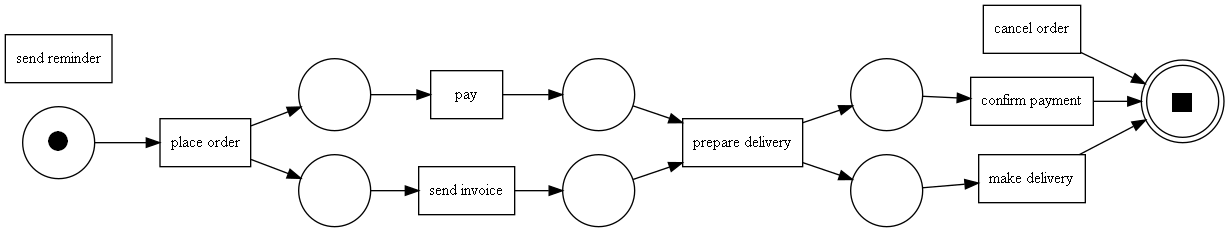

In [15]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

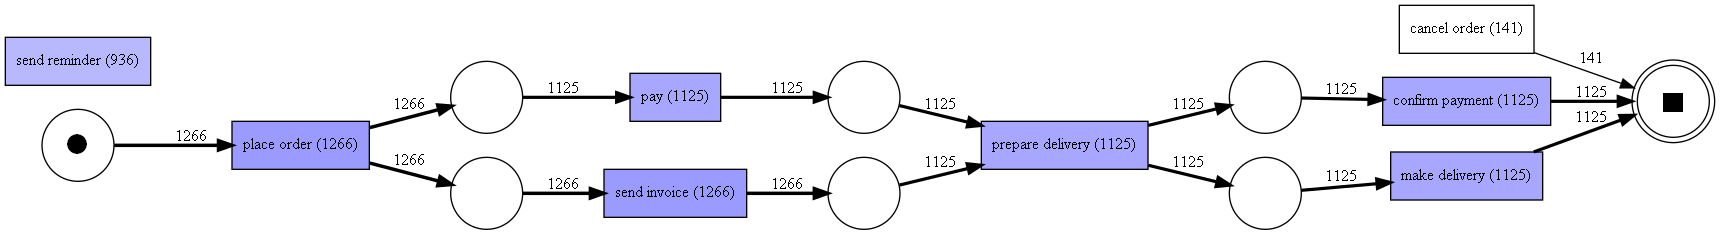

In [26]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz2 = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz2)

## Delete "send reminders" after the first one

In [17]:
# how many cases with more than one "send reminder"?
events[events['concept:name']=='send reminder'].groupby('case:concept:name')['concept:name'].count().value_counts()

2    316
1    304
Name: concept:name, dtype: int64

In [18]:
# include cumulative count for each case and activity
events['cumcount_activity']=events.groupby(['case:concept:name','concept:name']).transform('cumcount')

In [19]:
# create cleaned dataset
events_cleaned = events.copy()
events_cleaned = events_cleaned[~((events_cleaned['cumcount_activity']>0) & (events_cleaned['concept:name']=='send reminder'))]
#events_cleaned = events_cleaned[events_cleaned['cumcount_activity']==0]

In [21]:
## Convert to log format
log_cleaned = log_converter.apply(events_cleaned)

### Directly-follows graph with cleaned log

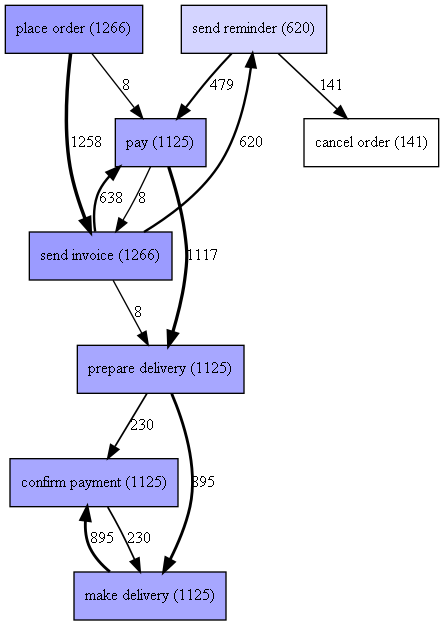

In [22]:
#Create graph from log
dfg_cleaned = dfg_discovery.apply(log_cleaned)

# viz
gviz_cleaned = dfg_visualization.apply(dfg_cleaned, log=log_cleaned, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz_cleaned)

### Alpha miner with cleaned log

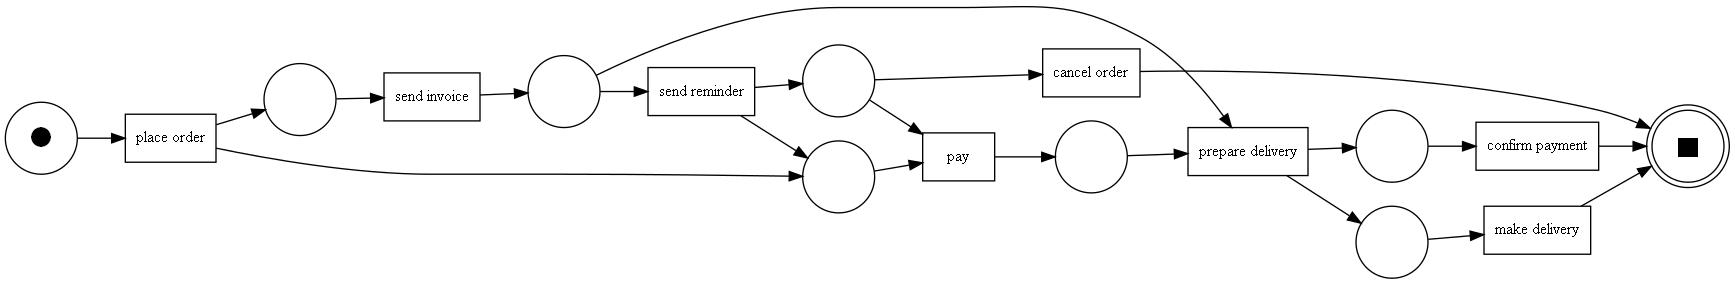

In [23]:
# alpha miner
net_cleaned, initial_marking_cleaned, final_marking_cleaned = alpha_miner.apply(log_cleaned)

# Visualise
gviz_cleaned1 = pn_visualizer.apply(net_cleaned, initial_marking_cleaned, final_marking_cleaned)
pn_visualizer.view(gviz_cleaned1)

In [ ]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz2_cleaned = pn_visualizer.apply(net_cleaned, initial_marking_cleaned, final_marking_cleaned, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log_cleaned)

pn_visualizer.view(gviz2_cleaned)

### Reachability graph for cleaned log

In [24]:
from pm4py.objects.petri_net.utils import reachability_graph
ts = reachability_graph.construct_reachability_graph(net_cleaned, initial_marking_cleaned)
            

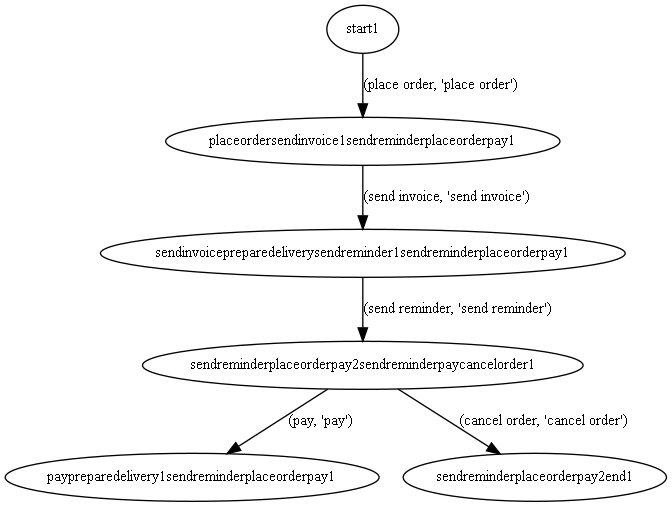

In [25]:
from pm4py.visualization.transition_system import visualizer as ts_visualizer
gviz3 = ts_visualizer.apply(ts)
ts_visualizer.view(gviz3)
                                